In [ ]:
%load_ext autoreload
%autoreload 2

import cv2
import torch
from kornia_moons.feature import *
from kornia_moons.viz import *

import pycolmap
import os
import h5py
import numpy as np
import kornia as K
import kornia.feature as KF
from fastprogress import progress_bar
import matplotlib.pyplot as plt

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cpu')



## Download example data

In [ ]:

!wget http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip

--2024-11-08 15:22:35--  http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34534975 (33M) [application/zip]
Saving to: ‘wooden_lady_subset.zip’

wooden_lady_subset. 100%[===================>]  32,93M  5,87MB/s    in 5,7s    

2024-11-08 15:22:40 (5,77 MB/s) - ‘wooden_lady_subset.zip’ saved [34534975/34534975]



In [ ]:
%%capture
!unzip -o wooden_lady_subset.zip

<matplotlib.image.AxesImage>

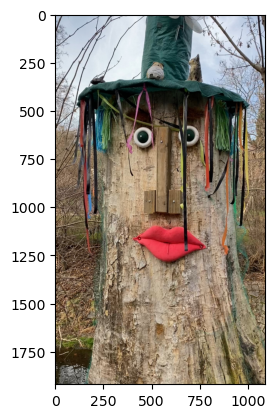

In [ ]:
dirname = 'wooden_lady_subset'
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.jpg' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

In [ ]:
from kornia_moons.feature import laf_from_opencv_SIFT_kpts

def sift_to_rootsift(x: torch.Tensor, eps=1e-6) -> torch.Tensor:
    x = torch.nn.functional.normalize(x, p=1, dim=-1, eps=eps)
    x.clip_(min=eps).sqrt_()
    return torch.nn.functional.normalize(x, p=2, dim=-1, eps=eps)

def detect_sift(img_fnames,
                    num_feats = 2048,
                    device=torch.device('cpu'),
                    feature_dir = '.featureout', resize_to = (800, 600)):
    sift = cv2.SIFT_create(num_feats, edgeThreshold=-1000, contrastThreshold=-1000)
    if not os.path.isdir(feature_dir):
        os.makedirs(feature_dir)
    with h5py.File(f'{feature_dir}/lafs.h5', mode='w') as f_laf, \
         h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='w') as f_desc:
        for img_path in progress_bar(img_fnames):
            img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            hw1 = torch.tensor(img1.shape[:2], device=device)
            img_fname = img_path.split('/')[-1]
            key = img_fname
            kpts1, descs1 = sift.detectAndCompute(img1, None)
            lafs1 = laf_from_opencv_SIFT_kpts(kpts1)
            descs1 = sift_to_rootsift(torch.from_numpy(descs1)).to(device)
            desc_dim = descs1.shape[-1]
            kpts = KF.get_laf_center(lafs1).reshape(-1, 2).detach().cpu().numpy()
            descs1 = descs1.reshape(-1, desc_dim).detach().cpu().numpy()
            f_laf[key] = lafs1.detach().cpu().numpy()
            f_kp[key] = kpts
            f_desc[key] = descs1
    return


## Detect KeyNetAffNet features

In [ ]:
detect_sift(img_fnames, 2048, device=device, resize_to=None)

In [ ]:
feature_dir = '.featureout'
with h5py.File(f'{feature_dir}/lafs.h5', mode='r') as f_laf:
    img1 = load_torch_image(img_fnames[0])
    key = img_fnames[0].split('/')[-1]
    lafs = torch.from_numpy(f_laf[key][...])
    visualize_LAF(img1, lafs)


NameError: name 'visualize_LAF' is not defined

## Matching

In [ ]:
def get_unique_idxs(A):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=0, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout',
                   device=torch.device('cpu'),
                   min_matches=15):
    matcher = K.feature.LightGlueMatcher('sift').eval().to(device)
    with h5py.File(f'{feature_dir}/lafs.h5', mode='r') as f_laf, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='r') as f_desc, \
        h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        with torch.inference_mode():
            for pair_idx in progress_bar(index_pairs):
                idx1, idx2 = pair_idx
                fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
                key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
                lafs1 = torch.from_numpy(f_laf[key1][...]).to(device)
                lafs2 = torch.from_numpy(f_laf[key2][...]).to(device)
                desc1 = torch.from_numpy(f_desc[key1][...]).to(device)
                desc2 = torch.from_numpy(f_desc[key2][...]).to(device)
                img1, img2 = cv2.imread(fname1), cv2.imread(fname2)
                hw1, hw2 = img1.shape[:2], img2.shape[:2]
                dists, idxs = matcher(desc1, desc2,
                                              lafs1, lafs2, # Adalam takes into account also geometric information
                                              hw1=hw1, hw2=hw2) # Adalam also benefits from knowing image size
                if len(idxs)  == 0:
                    continue
                n_matches = len(idxs)
                if False:
                    print (f'{key1}-{key2}: {n_matches} matches')
                group  = f_match.require_group(key1)
                if n_matches >= min_matches:
                     group.create_dataset(key2, data=idxs.detach().cpu().numpy().reshape(-1, 2))
    return


In [ ]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        index_pairs.append((i,j))


In [ ]:
match_features(img_fnames, index_pairs, device=torch.device('cpu'))

Loaded LightGlue model


## Import into colmap and run reconstruction

In [ ]:
from h5_to_db import add_keypoints, add_matches, COLMAPDatabase

def import_into_colmap(img_dir,
                       feature_dir ='.featureout',
                       database_path = 'colmap.db',
                       img_ext='.jpg'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, img_ext, 'simple-pinhole', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )

    db.commit()
    return

database_path = 'colmap.db'
!rm {database_path}
import_into_colmap(dirname, database_path=database_path)

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 175/231 [00:00<00:00, 12975.36it/s]


In [ ]:
output_path = 'colmap_rec_sift'


In [ ]:

def run_reconstruction_glomap(image_dir, output_path = 'glomap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    !glomap mapper --database_path {database_path} --output_path {output_path} --TrackEstablishment.min_num_view_per_track 2
    return 
run_reconstruction_glomap(dirname, 'glomap_rec_sift', database_path)

I20241108 15:57:32.591411 1315259 misc.cc:198] 
Exhaustive feature matching
I20241108 15:57:32.594735 1315259 feature_matching.cc:231] Matching block [1/1, 1/1]
I20241108 15:57:32.597434 1315259 feature_matching.cc:46]  in 0.003s
I20241108 15:57:32.597460 1315259 timer.cc:91] Elapsed time: 0.000 [minutes]


 Loading Images 23 / 23
 Loading Image Pair 175 / 175
I20241108 15:57:32.810406 1315281 colmap_converter.cc:303] Pairs read done. 10 / 175 are invalid
I20241108 15:57:32.812225 1315281 global_mapper.cc:80] Loaded database
-------------------------------------
Running preprocessing ...
-------------------------------------
I20241108 15:57:32.812613 1315281 view_graph_manipulation.cc:249] Decompose relative pose for 0 pairs
I20241108 15:57:32.812695 1315281 view_graph_manipulation.cc:303] Decompose relative pose done. 0 pairs are pure rotation
I20241108 15:57:32.812785 1315281 timer.cc:87] Elapsed time: 0.00052 [seconds]
-------------------------------------
Running view graph calibration ...
-------------------------------------
I20241108 15:57:32.812804 1315281 view_graph_calibration.cc:16] Start ViewGraphCalibrator
I20241108 15:57:32.822386 1315281 view_graph_calibration.cc:148] 0 cameras are rejected in view graph calibration
I20241108 15:57:32.822438 1315281 view_graph_calibration.c

 Global bundle adjustment iteration 5 / 5
I20241108 15:57:33.861020 1315281 timer.cc:87] Elapsed time: 0.09958 [seconds]
-------------------------------------
Running bundle adjustment ...
-------------------------------------
I20241108 15:57:33.861047 1315281 global_mapper.cc:273] Bundle adjustment start
I20241108 15:57:33.939496 1315281 bundle_adjustment.cc:48] Ceres Solver Report: Iterations: 13, Initial cost: 4.969151e+03, Final cost: 4.666621e+03, Termination: CONVERGENCE
I20241108 15:57:33.939611 1315281 image_undistorter.cc:20] Undistorting images..
I20241108 15:57:33.939795 1315281 image_undistorter.cc:41] Image undistortion done
I20241108 15:57:33.939855 1315281 global_mapper.cc:281] Filtering tracks by reprojection ...
I20241108 15:57:33.940076 1315281 track_filter.cc:48] Filtered 0 / 1670 tracks by reprojection error
I20241108 15:57:33.963900 1315281 bundle_adjustment.cc:48] Ceres Solver Report: Iterations: 1, Initial cost: 4.666621e+03, Final cost: 4.666621e+03, Termination

In [ ]:

def run_reconstruction(image_dir, output_path = 'colmap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    maps = pycolmap.incremental_mapping(database_path, dirname, output_path)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
    maps[0].write(output_path)
    return maps

In [ ]:
maps = run_reconstruction(dirname, output_path, database_path)

I20241108 15:53:14.242744 1311571 misc.cc:198] 
Exhaustive feature matching
I20241108 15:53:14.245966 1311571 feature_matching.cc:231] Matching block [1/1, 1/1]
I20241108 15:53:14.575067 1311571 feature_matching.cc:46]  in 0.329s
I20241108 15:53:14.576274 1311571 timer.cc:91] Elapsed time: 0.006 [minutes]
I20241108 15:53:14.582705 1311589 misc.cc:198] 
Loading database
I20241108 15:53:14.583245 1311589 database_cache.cc:54] Loading cameras...
I20241108 15:53:14.583266 1311589 database_cache.cc:64]  23 in 0.000s
I20241108 15:53:14.583276 1311589 database_cache.cc:72] Loading matches...
I20241108 15:53:14.583458 1311589 database_cache.cc:78]  165 in 0.000s
I20241108 15:53:14.583465 1311589 database_cache.cc:94] Loading images...
I20241108 15:53:14.584040 1311589 database_cache.cc:143]  23 in 0.001s (connected 23)
I20241108 15:53:14.584048 1311589 database_cache.cc:154] Building correspondence graph...
I20241108 15:53:14.587311 1311589 database_cache.cc:190]  in 0.003s (ignored 0)
I202411

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.419576e+03    0.00e+00    5.15e+05   0.00e+00   0.00e+00  1.00e+04        0    1.04e-03    5.28e-03
   1  6.390867e+02    7.80e+02    3.44e+05   1.79e+02   8.51e-01  1.53e+04        1    1.87e-03    7.16e-03
   2  4.390989e+02    2.00e+02    5.84e+04   8.90e+01   9.83e-01  4.59e+04        1    4.74e-04    7.65e-03
   3  4.568487e+02   -1.77e+01    5.84e+04   6.79e+01  -3.43e-01  2.30e+04        1    2.30e-04    7.88e-03
   4  4.076274e+02    3.15e+01    1.21e+05   4.61e+01   8.44e-01  3.40e+04        1    4.42e-04    8.33e-03
   5  3.950788e+02    1.25e+01    1.92e+05   3.29e+01   4.26e-01  3.39e+04        1    4.53e-04    8.78e-03
   6  3.734980e+02    2.16e+01    1.29e+05   2.26e+01   7.01e-01  3.63e+04        1    4.51e-04    9.24e-03
   7  3.614939e+02    1.20e+01    9.79e+04   2.15e+01   6.28e-01  3.69e+04        1    4.51e-04    9.69e-03
   8  3.518505e+02    9.64e+

I20241108 15:53:14.784823 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:14.784835 1311589 bundle_adjustment.cc:942] 
    Residuals : 4786
   Parameters : 2481
   Iterations : 9
         Time : 0.0142939 [s]
 Initial cost : 0.470234 [px]
   Final cost : 0.468378 [px]
  Termination : Convergence

I20241108 15:53:14.785254 1311589 incremental_mapper.cc:175] => Completed observations: 0
I20241108 15:53:14.785378 1311589 incremental_mapper.cc:178] => Merged observations: 0
I20241108 15:53:14.785466 1311589 incremental_mapper.cc:160] => Filtered observations: 2
I20241108 15:53:14.785471 1311589 incremental_mapper.cc:119] => Changed observations: 0.000836
I20241108 15:53:14.785477 1311589 misc.cc:198] 
Global bundle adjustment
I20241108 15:53:14.800356 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:14.800377 1311589 bundle_adjustment.cc:942] 
    Residuals : 4782
   Parameters : 2481
   Iterations : 8
         

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.344323e+03    0.00e+00    2.52e+02   0.00e+00   0.00e+00  1.00e+04        0    8.84e-04    2.72e-03
   1  1.340330e+03    3.99e+00    4.48e+00   2.07e+00   9.99e-01  3.00e+04        1    2.58e-03    5.31e-03
   2  1.340261e+03    6.93e-02    7.86e+00   2.48e+00   1.00e+00  9.00e+04        1    2.45e-03    7.76e-03
   3  1.340197e+03    6.38e-02    2.84e+01   4.88e+00   9.78e-01  2.70e+05        1    2.37e-03    1.01e-02
   4  1.340155e+03    4.20e-02    4.63e+01   6.26e+00   9.13e-01  6.20e+05        1    2.37e-03    1.25e-02
   5  1.340141e+03    1.38e-02    1.52e+01   3.53e+00   9.86e-01  1.86e+06        1    2.43e-03    1.49e-02
   6  1.340140e+03    1.23e-03    1.66e+00   1.11e+00   1.03e+00  5.58e+06        1    2.36e-03    1.73e-02
   7  1.340140e+03    2.35e-05    1.72e+00   1.62e-01   1.07e+00  1.67e+07        1    2.38e-03    1.97e-02
   8  1.340140e+03    2.97e-

I20241108 15:53:14.993265 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:14.993279 1311589 bundle_adjustment.cc:942] 
    Residuals : 6800
   Parameters : 2927
   Iterations : 8
         Time : 0.0208991 [s]
 Initial cost : 0.517061 [px]
   Final cost : 0.516192 [px]
  Termination : Convergence

I20241108 15:53:14.993831 1311589 incremental_mapper.cc:175] => Completed observations: 0
I20241108 15:53:14.994019 1311589 incremental_mapper.cc:178] => Merged observations: 0
I20241108 15:53:14.994127 1311589 incremental_mapper.cc:160] => Filtered observations: 0
I20241108 15:53:14.994132 1311589 incremental_mapper.cc:119] => Changed observations: 0.000000
I20241108 15:53:14.994138 1311589 incremental_mapper.cc:167] => Filtered images: 0
I20241108 15:53:15.009883 1311589 misc.cc:198] 
Registering image #18 (7)
I20241108 15:53:15.009907 1311589 incremental_mapper.cc:495] => Image sees 272 / 578 points
I20241108 15:53:15.018455 1311589 misc.cc:205] 
Pose

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.061635e+03    0.00e+00    8.13e+02   0.00e+00   0.00e+00  1.00e+04        0    1.38e-03    3.98e-03
   1  2.045157e+03    1.65e+01    1.14e+02   1.32e+01   1.00e+00  3.00e+04        1    3.26e-03    7.26e-03
   2  2.043779e+03    1.38e+00    1.54e+02   1.41e+01   1.00e+00  9.00e+04        1    2.69e-03    9.96e-03
   3  2.043439e+03    3.40e-01    8.24e+01   8.95e+00   1.01e+00  2.70e+05        1    2.83e-03    1.28e-02
   4  2.043403e+03    3.57e-02    1.11e+01   2.89e+00   1.04e+00  8.10e+05        1    2.76e-03    1.56e-02
   5  2.043402e+03    1.35e-03    1.88e+00   5.24e-01   1.09e+00  2.43e+06        1    2.68e-03    1.82e-02
   6  2.043402e+03    3.54e-05    4.99e-01   1.21e-01   1.17e+00  7.29e+06        1    2.67e-03    2.09e-02
   7  2.043402e+03    1.51e-06    3.68e-02   3.24e-02   1.24e+00  2.19e+07        1    2.89e-03    2.38e-02
iter      cost      cost_cha

I20241108 15:53:15.200613 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:15.200632 1311589 bundle_adjustment.cc:942] 
    Residuals : 8504
   Parameters : 3256
   Iterations : 8
         Time : 0.028666 [s]
 Initial cost : 0.521316 [px]
   Final cost : 0.517504 [px]
  Termination : Convergence

I20241108 15:53:15.201346 1311589 incremental_mapper.cc:175] => Completed observations: 0
I20241108 15:53:15.201604 1311589 incremental_mapper.cc:178] => Merged observations: 6
I20241108 15:53:15.201737 1311589 incremental_mapper.cc:160] => Filtered observations: 0
I20241108 15:53:15.201743 1311589 incremental_mapper.cc:119] => Changed observations: 0.001411
I20241108 15:53:15.201750 1311589 misc.cc:198] 
Global bundle adjustment
I20241108 15:53:15.227692 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:15.227716 1311589 bundle_adjustment.cc:942] 
    Residuals : 8504
   Parameters : 3253
   Iterations : 7
         T

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.592768e+03    0.00e+00    1.21e+03   0.00e+00   0.00e+00  1.00e+04        0    1.48e-03    4.47e-03
   1  2.562159e+03    3.06e+01    2.96e+02   3.73e+01   1.01e+00  3.00e+04        1    3.81e-03    8.28e-03
   2  2.558996e+03    3.16e+00    1.89e+02   3.40e+01   1.04e+00  9.00e+04        1    3.41e-03    1.17e-02
   3  2.558412e+03    5.83e-01    9.73e+01   2.22e+01   1.05e+00  2.70e+05        1    3.41e-03    1.51e-02
   4  2.558346e+03    6.61e-02    1.86e+01   8.44e+00   1.07e+00  8.10e+05        1    3.42e-03    1.85e-02
   5  2.558343e+03    3.16e-03    1.61e+00   1.76e+00   1.12e+00  2.43e+06        1    3.44e-03    2.20e-02
   6  2.558343e+03    1.02e-04    3.91e-01   2.92e-01   1.17e+00  7.29e+06        1    3.62e-03    2.56e-02
   7  2.558343e+03    3.73e-06    1.07e-01   4.93e-02   1.19e+00  2.19e+07        1    3.43e-03    2.90e-02
   8  2.558343e+03    1.49e-

I20241108 15:53:15.422953 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:15.422971 1311589 bundle_adjustment.cc:942] 
    Residuals : 9760
   Parameters : 3387
   Iterations : 8
         Time : 0.0325701 [s]
 Initial cost : 0.542077 [px]
   Final cost : 0.540299 [px]
  Termination : Convergence

I20241108 15:53:15.424327 1311589 incremental_mapper.cc:175] => Completed observations: 0
I20241108 15:53:15.424626 1311589 incremental_mapper.cc:178] => Merged observations: 11
I20241108 15:53:15.424772 1311589 incremental_mapper.cc:160] => Filtered observations: 1
I20241108 15:53:15.424777 1311589 incremental_mapper.cc:119] => Changed observations: 0.002459
I20241108 15:53:15.424784 1311589 misc.cc:198] 
Global bundle adjustment
I20241108 15:53:15.444267 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:15.444284 1311589 bundle_adjustment.cc:942] 
    Residuals : 9758
   Parameters : 3384
   Iterations : 4
        

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.130396e+03    0.00e+00    1.98e+03   0.00e+00   0.00e+00  1.00e+04        0    1.66e-03    5.03e-03
   1  3.104746e+03    2.56e+01    3.91e+01   1.21e+01   9.99e-01  3.00e+04        1    5.01e-03    1.01e-02
   2  3.104402e+03    3.44e-01    4.11e+01   8.38e+00   1.03e+00  9.00e+04        1    4.11e-03    1.42e-02
   3  3.104345e+03    5.66e-02    1.81e+01   3.80e+00   1.04e+00  2.70e+05        1    4.10e-03    1.83e-02
   4  3.104336e+03    9.71e-03    9.15e+00   1.09e+00   1.03e+00  8.10e+05        1    4.17e-03    2.25e-02
   5  3.104335e+03    7.57e-04    1.95e+00   2.25e-01   1.04e+00  2.43e+06        1    4.74e-03    2.72e-02
   6  3.104335e+03    1.74e-05    8.90e-01   4.25e-02   1.08e+00  7.29e+06        1    4.30e-03    3.15e-02
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.092827e+03    0.00e+

I20241108 15:53:15.649858 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:15.649883 1311589 bundle_adjustment.cc:942] 
    Residuals : 7952
   Parameters : 1907
   Iterations : 15
         Time : 0.0337892 [s]
 Initial cost : 0.51287 [px]
   Final cost : 0.497985 [px]
  Termination : Convergence

I20241108 15:53:15.651115 1311589 incremental_mapper.cc:78] => Merged observations: 93
I20241108 15:53:15.651130 1311589 incremental_mapper.cc:79] => Completed observations: 14
I20241108 15:53:15.651136 1311589 incremental_mapper.cc:81] => Filtered observations: 52
I20241108 15:53:15.651142 1311589 incremental_mapper.cc:90] => Changed observations: 0.039990
I20241108 15:53:15.660504 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:15.660517 1311589 bundle_adjustment.cc:942] 
    Residuals : 7892
   Parameters : 1883
   Iterations : 3
         Time : 0.00776482 [s]
 Initial cost : 0.5584 [px]
   Final cost : 0.5473 [

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.729263e+03    0.00e+00    1.73e+03   0.00e+00   0.00e+00  1.00e+04        0    1.98e-03    6.05e-03
   1  3.699600e+03    2.97e+01    4.35e+01   9.63e+00   1.00e+00  3.00e+04        1    5.61e-03    1.17e-02
   2  3.699159e+03    4.42e-01    6.11e+01   8.44e+00   1.00e+00  9.00e+04        1    5.01e-03    1.67e-02
   3  3.699009e+03    1.50e-01    6.65e+01   6.91e+00   1.01e+00  2.70e+05        1    4.89e-03    2.16e-02
   4  3.698979e+03    3.00e-02    2.61e+01   3.01e+00   1.03e+00  8.10e+05        1    6.00e-03    2.76e-02
   5  3.698976e+03    2.22e-03    2.68e+00   7.16e-01   1.05e+00  2.43e+06        1    5.14e-03    3.27e-02
   6  3.698976e+03    5.80e-05    1.97e+00   1.23e-01   1.10e+00  7.29e+06        1    4.99e-03    3.77e-02
   7  3.698976e+03    1.33e-06    6.24e-02   2.13e-02   1.17e+00  2.19e+07        1    5.25e-03    4.30e-02
iter      cost      cost_cha

I20241108 15:53:15.859289 1311589 misc.cc:198] 
Registering image #15 (15)
I20241108 15:53:15.859311 1311589 incremental_mapper.cc:495] => Image sees 225 / 311 points
I20241108 15:53:15.867873 1311589 misc.cc:205] 
Pose refinement report
----------------------
I20241108 15:53:15.867893 1311589 bundle_adjustment.cc:942] 
    Residuals : 556
   Parameters : 7
   Iterations : 10
         Time : 0.00100708 [s]
 Initial cost : 0.701794 [px]
   Final cost : 0.577781 [px]
  Termination : Convergence

I20241108 15:53:15.868041 1311589 incremental_mapper.cc:40] => Continued observations: 215
I20241108 15:53:15.868249 1311589 incremental_mapper.cc:43] => Added observations: 58
I20241108 15:53:15.903128 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:15.903154 1311589 bundle_adjustment.cc:942] 
    Residuals : 5374
   Parameters : 722
   Iterations : 26
         Time : 0.0337429 [s]
 Initial cost : 0.561617 [px]
   Final cost : 0.542909 [px]
  Termination :

   2  4.195632e+03    1.25e+01    3.37e+02   9.24e+00   9.99e-01  9.00e+04        1    5.72e-03    1.94e-02
   3  4.195161e+03    4.71e-01    9.49e+01   7.36e+00   9.95e-01  2.70e+05        1    5.71e-03    2.51e-02
   4  4.195068e+03    9.30e-02    5.85e+01   5.54e+00   9.96e-01  8.10e+05        1    6.41e-03    3.15e-02
   5  4.195060e+03    8.43e-03    6.99e+00   1.72e+00   1.02e+00  2.43e+06        1    5.87e-03    3.74e-02
   6  4.195060e+03    1.55e-04    1.55e+00   2.26e-01   1.05e+00  7.29e+06        1    5.68e-03    4.31e-02
   7  4.195060e+03    1.53e-06    1.01e-01   1.98e-02   1.11e+00  2.19e+07        1    5.80e-03    4.89e-02
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  4.187937e+03    0.00e+00    1.33e+02   0.00e+00   0.00e+00  1.00e+04        0    2.21e-03    6.84e-03
   1  4.162598e+03    2.53e+01    4.10e+01   4.99e+00   1.00e+00  3.00e+04        1    7.50e-03    1.44e-02
   2  4.162370e+03    2.27e-

I20241108 15:53:16.070852 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:16.070873 1311589 bundle_adjustment.cc:942] 
    Residuals : 13566
   Parameters : 4160
   Iterations : 8
         Time : 0.0488389 [s]
 Initial cost : 0.558467 [px]
   Final cost : 0.55447 [px]
  Termination : Convergence

I20241108 15:53:16.071971 1311589 incremental_mapper.cc:175] => Completed observations: 1
I20241108 15:53:16.072350 1311589 incremental_mapper.cc:178] => Merged observations: 0
I20241108 15:53:16.072543 1311589 incremental_mapper.cc:160] => Filtered observations: 0
I20241108 15:53:16.072549 1311589 incremental_mapper.cc:119] => Changed observations: 0.000147
I20241108 15:53:16.072556 1311589 incremental_mapper.cc:167] => Filtered images: 0
I20241108 15:53:16.087265 1311589 misc.cc:198] 
Registering image #3 (16)
I20241108 15:53:16.087285 1311589 incremental_mapper.cc:495] => Image sees 160 / 802 points
I20241108 15:53:16.105265 1311589 misc.cc:205] 
Pose

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  4.666726e+03    0.00e+00    2.02e+03   0.00e+00   0.00e+00  1.00e+04        0    2.49e-03    7.64e-03
   1  4.602945e+03    6.38e+01    1.05e+02   1.42e+01   1.00e+00  3.00e+04        1    7.44e-03    1.51e-02
   2  4.601600e+03    1.35e+00    1.16e+02   9.25e+00   9.96e-01  9.00e+04        1    7.36e-03    2.25e-02
   3  4.600523e+03    1.08e+00    3.71e+01   1.30e+01   9.64e-01  2.70e+05        1    6.64e-03    2.91e-02
   4  4.599963e+03    5.60e-01    5.47e+01   1.36e+01   9.24e-01  6.92e+05        1    7.19e-03    3.63e-02
   5  4.599823e+03    1.40e-01    2.28e+01   6.92e+00   9.83e-01  2.08e+06        1    7.31e-03    4.36e-02
   6  4.599815e+03    7.81e-03    2.30e+00   1.73e+00   1.01e+00  6.23e+06        1    6.63e-03    5.02e-02
   7  4.599815e+03    6.36e-05    1.02e+00   1.74e-01   1.04e+00  1.87e+07        1    6.52e-03    5.68e-02
   8  4.599815e+03    4.38e-

I20241108 15:53:16.313719 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:16.313740 1311589 bundle_adjustment.cc:942] 
    Residuals : 15254
   Parameters : 4834
   Iterations : 7
         Time : 0.047878 [s]
 Initial cost : 0.548285 [px]
   Final cost : 0.548088 [px]
  Termination : Convergence

I20241108 15:53:16.315001 1311589 incremental_mapper.cc:175] => Completed observations: 0
I20241108 15:53:16.315467 1311589 incremental_mapper.cc:178] => Merged observations: 0
I20241108 15:53:16.315721 1311589 incremental_mapper.cc:160] => Filtered observations: 2
I20241108 15:53:16.315726 1311589 incremental_mapper.cc:119] => Changed observations: 0.000262
I20241108 15:53:16.315735 1311589 incremental_mapper.cc:167] => Filtered images: 0
I20241108 15:53:16.331316 1311589 misc.cc:198] 
Registering image #7 (18)
I20241108 15:53:16.331355 1311589 incremental_mapper.cc:495] => Image sees 233 / 941 points
I20241108 15:53:16.349805 1311589 misc.cc:205] 
Pose

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.404742e+03    0.00e+00    9.41e+03   0.00e+00   0.00e+00  1.00e+04        0    2.87e-03    9.13e-03
   1  5.315972e+03    8.88e+01    1.39e+01   5.32e+00   1.00e+00  3.00e+04        1    8.21e-03    1.73e-02
   2  5.315367e+03    6.05e-01    1.97e+00   2.05e+00   1.00e+00  9.00e+04        1    8.26e-03    2.56e-02
   3  5.315262e+03    1.05e-01    4.45e+00   2.77e+00   1.00e+00  2.70e+05        1    9.01e-03    3.46e-02
   4  5.315181e+03    8.07e-02    1.12e+01   4.06e+00   9.91e-01  8.10e+05        1    8.32e-03    4.30e-02
   5  5.315151e+03    3.03e-02    8.30e+00   3.37e+00   9.88e-01  2.43e+06        1    9.58e-03    5.25e-02
   6  5.315148e+03    3.29e-03    1.97e+00   1.23e+00   1.00e+00  7.29e+06        1    8.45e-03    6.10e-02
   7  5.315148e+03    5.93e-05    1.90e+00   1.73e-01   1.02e+00  2.19e+07        1    9.10e-03    7.01e-02
   8  5.315148e+03    3.11e-

I20241108 15:53:16.538647 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:16.538667 1311589 bundle_adjustment.cc:942] 
    Residuals : 17578
   Parameters : 5721
   Iterations : 9
         Time : 0.0777812 [s]
 Initial cost : 0.554502 [px]
   Final cost : 0.549886 [px]
  Termination : Convergence

I20241108 15:53:16.540073 1311589 incremental_mapper.cc:175] => Completed observations: 0
I20241108 15:53:16.540542 1311589 incremental_mapper.cc:178] => Merged observations: 10
I20241108 15:53:16.540797 1311589 incremental_mapper.cc:160] => Filtered observations: 8
I20241108 15:53:16.540803 1311589 incremental_mapper.cc:119] => Changed observations: 0.002048
I20241108 15:53:16.540812 1311589 misc.cc:198] 
Global bundle adjustment
I20241108 15:53:16.605080 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:16.605106 1311589 bundle_adjustment.cc:942] 
    Residuals : 17554
   Parameters : 5709
   Iterations : 7
      

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.239894e+03    0.00e+00    4.66e+03   0.00e+00   0.00e+00  1.00e+04        0    3.72e-03    1.11e-02
   1  6.187389e+03    5.25e+01    1.94e+01   5.33e+00   1.00e+00  3.00e+04        1    9.59e-03    2.07e-02
   2  6.187169e+03    2.20e-01    9.58e+00   2.64e+00   1.00e+00  9.00e+04        1    9.02e-03    2.97e-02
   3  6.186954e+03    2.15e-01    1.01e+01   3.42e+00   9.94e-01  2.70e+05        1    8.82e-03    3.85e-02
   4  6.186755e+03    2.00e-01    2.98e+01   5.07e+00   9.73e-01  8.10e+05        1    8.98e-03    4.75e-02
   5  6.186669e+03    8.58e-02    2.42e+01   4.43e+00   9.66e-01  2.43e+06        1    8.82e-03    5.63e-02
   6  6.186657e+03    1.19e-02    4.35e+00   1.73e+00   9.98e-01  7.29e+06        1    9.22e-03    6.56e-02
   7  6.186657e+03    2.45e-04    1.93e+00   2.59e-01   1.01e+00  2.19e+07        1    9.96e-03    7.55e-02
   8  6.186657e+03    1.03e-

I20241108 15:53:16.971220 1311589 misc.cc:198] 
Registering image #1 (23)
I20241108 15:53:16.971241 1311589 incremental_mapper.cc:495] => Image sees 203 / 553 points
I20241108 15:53:16.988082 1311589 misc.cc:205] 
Pose refinement report
----------------------
I20241108 15:53:16.988111 1311589 bundle_adjustment.cc:942] 
    Residuals : 370
   Parameters : 7
   Iterations : 12
         Time : 0.000822067 [s]
 Initial cost : 0.737933 [px]
   Final cost : 0.553588 [px]
  Termination : Convergence

I20241108 15:53:16.988206 1311589 incremental_mapper.cc:40] => Continued observations: 154
I20241108 15:53:16.988687 1311589 incremental_mapper.cc:43] => Added observations: 247
I20241108 15:53:17.012696 1311589 misc.cc:205] 
Bundle adjustment report
------------------------
I20241108 15:53:17.012724 1311589 bundle_adjustment.cc:942] 
    Residuals : 5332
   Parameters : 863
   Iterations : 16
         Time : 0.022809 [s]
 Initial cost : 0.657046 [px]
   Final cost : 0.525856 [px]
  Termination :

In [ ]:
print (maps[0].summary())

Reconstruction:
	num_reg_images = 23
	num_cameras = 23
	num_points3D = 2175
	num_observations = 10771
	mean_track_length = 4.95218
	mean_observations_per_image = 468.304
	mean_reprojection_error = 0.815522


## Visualize with colmap GUI (yes, it is cheating)

In [ ]:
!colmap gui

qt.qpa.fonts: Populating font family aliases took 59 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 
2024-11-08 15:53:33.524 colmap[64639:1311887] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-08 15:53:33.524 colmap[64639:1311887] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2024-11-08 15:53:36.520 colmap[64639:1311887] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
QOpenGLVertexArrayObject::destroy() failed to restore current context


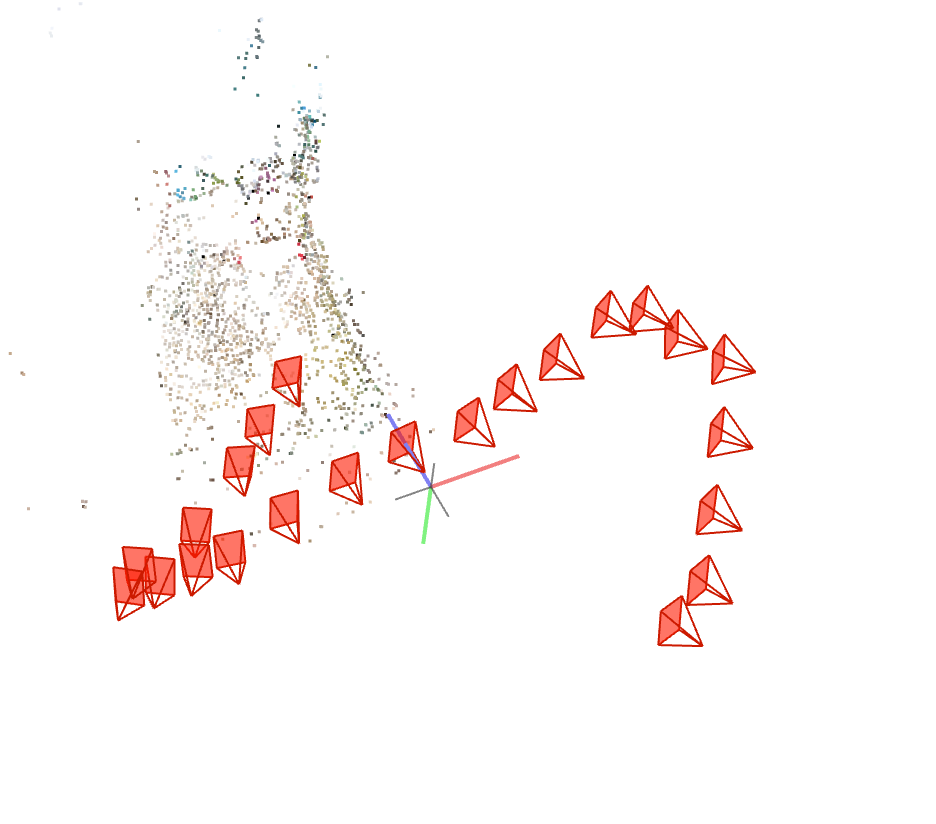